In [90]:
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable

import pyro
from pyro.distributions import Normal
from pyro.infer import SVI
from pyro.optim import Adam as Adam_pyro

import quandl
import pendulum
import pandas as pd
import io
import requests
import time

%matplotlib inline
from matplotlib import pyplot as plt

In [91]:
quandl.ApiConfig.api_key = '7ixwozwzrZ2ZU558396x'
 
def quandl_stocks(symbol, start_date='2010-1-1', end_date=None):
    if not end_date:
        end_date = pendulum.now().to_iso8601_string() 
    return quandl.get_table('WIKI/PRICES', ticker=symbol, date={'gte':start_date, 'lte':end_date}, paginate=True)
 
def quandl_fundamentals(symbol):
    return quandl.get_table('ZACKS/FC', ticker=symbol, qopts={"columns":["per_end_date", "wavg_shares_out", 
                                                                         "wavg_shares_out_diluted", "eps_basic_net", 
                                                                         "eps_diluted_net"]})

In [119]:
symbol = 'F'
df_price = quandl_stocks(symbol, start_date='2010-1-1')
df_fundamentals = quandl_fundamentals(symbol)

df_price['date'] = pd.to_datetime(df_price['date'])
df_fundamentals['per_end_date']=pd.to_datetime(df_fundamentals['per_end_date'])
df_price = df_price.set_index("date")
df_fundamentals = df_fundamentals.set_index("per_end_date")

df_fundamentals = df_fundamentals.sort_index()
df_price = df_price.sort_index()
df_fundamentals.index.name='date'

df_price = df_price[~df_price.index.duplicated(keep='first')]
df_fundamentals = df_fundamentals[~df_fundamentals.index.duplicated(keep='first')]

In [120]:
df_price.head(5)

,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
date,,,,,,,,,,,,,
2010-01-04,F,10.17,10.28,10.0455,10.28,60855800.0,0.0,1.0,8.016056,8.102759,7.917924,8.102759,60855800.0
2010-01-05,F,10.45,11.24,10.4000,10.96,215620200.0,0.0,1.0,8.236754,8.859436,8.197343,8.638739,215620200.0
2010-01-06,F,11.21,11.46,11.1300,11.37,200070600.0,0.0,1.0,8.835790,9.032842,8.772734,8.961903,200070600.0
2010-01-07,F,11.46,11.69,11.3200,11.66,130201700.0,0.0,1.0,9.032842,9.214129,8.922493,9.190483,130201700.0
2010-01-08,F,11.67,11.74,11.4600,11.69,130463000.0,0.0,1.0,9.198365,9.253539,9.032842,9.214129,130463000.0


In [123]:
df = df_price.iloc[:,-5:]
# df = pd.concat([df_price, df_fundamentals], axis=1)
df = df.fillna(method='ffill')
df = df.dropna()
df = df.loc[:,'adj_open':]

In [124]:
df.head(5)

,adj_open,adj_high,adj_low,adj_close,adj_volume
date,,,,,
2010-01-04,8.016056,8.102759,7.917924,8.102759,60855800.0
2010-01-05,8.236754,8.859436,8.197343,8.638739,215620200.0
2010-01-06,8.835790,9.032842,8.772734,8.961903,200070600.0
2010-01-07,9.032842,9.214129,8.922493,9.190483,130201700.0
2010-01-08,9.198365,9.253539,9.032842,9.214129,130463000.0


In [125]:
X = df.values
sigma = X.max(axis=0)
X /= sigma

In [126]:
daily_delta = (df['adj_close']-df['adj_open'])/df['adj_open']
daily_delta = daily_delta.values
X = np.hstack([X, daily_delta[:, None]])

In [127]:
Y = daily_delta.copy()
Y = df['adj_close'].values
data_target = Y[1:]
data_feature = X[:-1]

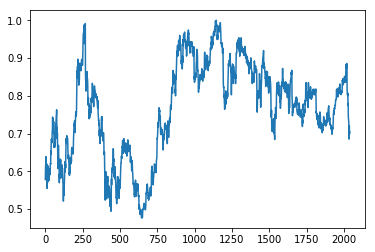

In [266]:
plt.plot(data_target)

# Build a simple NN

In [286]:
from keras.models import Model
from keras.layers import (Input, Dense, Lambda, Conv1D, Reshape, Flatten, GaussianNoise,
                          MaxPooling1D, ActivityRegularization, Activation, GRU)
from keras import backend as K
from keras.regularizers import l2, Regularizer
from keras.optimizers import Adam
import keras
import tensorflow as tf

In [295]:
num_hidden = 8

In [302]:
def feature_price(num_features=6, activation='relu', summary=False):
    act = Activation(activation)

    inputs = Input(shape=(num_features,))
    x = Dense(num_hidden)(inputs)
    x = act(x)

    for _ in range(9):
        x = Dense(num_hidden)(x)
        x = act(x)

    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    opt = Adam()

    if summary:
        model.summary()
    return model, lambda: model.compile(optimizer=opt, loss='mse', metrics=['mse'])


In [303]:
model_nn, build = feature_price(num_features=data_feature.shape[1])
build()

In [304]:
early = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto'
)
tmpfilename = f'Navie_NN.hdf5'
best = keras.callbacks.ModelCheckpoint(
    filepath=tmpfilename,
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    period=1
)

In [305]:
model_nn.fit(x=data_feature, y=data_target, validation_split=0.1, epochs=5, callbacks=[early, best])

Train on 1835 samples, validate on 204 samples
Epoch 1/5
1835/1835 [==============================] - 4s 2ms/step - loss: 0.0661 - mean_squared_error: 0.0661 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 2/5
1835/1835 [==============================] - 0s 118us/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 3/5
1835/1835 [==============================] - 0s 124us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 4/5
1835/1835 [==============================] - 0s 123us/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 5/5
1835/1835 [==============================] - 0s 131us/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0015 - val_mean_squared_error: 0.0015


In [306]:
pred_nn = model_nn.predict(data_feature)

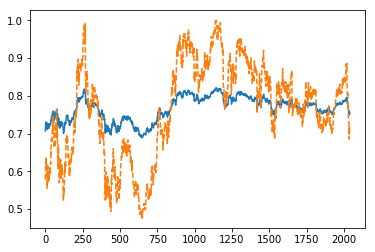

In [307]:
plt.plot(pred_nn)
plt.plot(data_target, '--')

In [308]:
weights_nn = model_nn.get_weights()

In [309]:
std_init = [np.log(np.exp(0.1*np.max(np.abs(weights)))-1) for weights in weights_nn]

In [310]:
# weights_nn = [0 * weights for weights in weights_nn]

# std_init = [-3] * len(weights_nn)

# Build Bayesian Model

In [311]:
data_feature_train = torch.Tensor(data_feature[:-200])
data_target_train = torch.Tensor(data_target[:-200])
data = torch.Tensor(np.hstack([data_feature_train, data_target_train[:,None]]))
data_feature_test = data_feature[-200:]
data_target_test = data_target[-200:]

In [312]:
data = Variable(data)
data_feature_test = Variable(torch.Tensor(data_feature_test))

In [313]:
pyro.get_param_store().clear()

In [314]:
class Network(torch.nn.Module):
    def __init__(self, n_feature, n_hidden):
        super(Network, self).__init__()
        self.input = nn.Linear(n_feature, n_hidden)
        for i in range(9):
            setattr(self, f'hidden{i}', nn.Linear(n_hidden, n_hidden))
        self.output = nn.Linear(n_hidden, 1)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.input(x)
        x = self.activation(x)
        for i in range(9):
            x = getattr(self, f'hidden{i}')(x)
            x = self.activation(x)
        x = self.output(x)
        return nn.Sigmoid()(x)
        return x

In [315]:
regression_model = Network(data_feature_train.shape[1], num_hidden)

In [316]:
# def model(data):
#     data_feature = data[:,:-1]
#     data_target = data[:,-1]
#     p=data_feature.shape[1]
    
#     mu_input = Variable(torch.Tensor(weights_nn[0].T))
#     sigma_input = Variable(std_init[0] * torch.ones(num_hidden,p))
#     bias_mu_input = Variable(torch.Tensor(weights_nn[1]))
#     bias_sigma_input = Variable(std_init[1] * torch.ones(num_hidden))    
#     w_prior_input, b_prior_input = Normal(mu_input, sigma_input), Normal(bias_mu_input, bias_sigma_input)
    
#     mu_output = Variable(torch.Tensor(weights_nn[-2].T))
#     sigma_output = Variable(std_init[-2] * torch.ones(1,num_hidden))
#     bias_mu_output = Variable(torch.Tensor(weights_nn[-1]))
#     bias_sigma_output = Variable(std_init[-2] * torch.ones(1))    
#     w_prior_output, b_prior_output = Normal(mu_output, sigma_output), Normal(bias_mu_output, bias_sigma_output)
    
#     priors = {'input.weight': w_prior_input, 'input.bias': b_prior_input,
#               'output.weight': w_prior_output, 'output.bias': b_prior_output}
    
#     mu_hidden, sigma_hidden, bias_mu_hidden, bias_sigma_hidden, \
#     w_prior_hidden, b_prior_hidden = ({} for _ in range(6))
#     for i in range(0,18,2):
#         assert weights_nn[i+2].shape == (num_hidden, num_hidden)
#         index = int(i/2)
#         mu_hidden[index] = Variable(torch.Tensor(weights_nn[i+2].T))
#         sigma_hidden[index] = Variable(std_init[i+2] * torch.ones(num_hidden, num_hidden))
#         bias_mu_hidden[index] = Variable(torch.Tensor(weights_nn[i+3]))
#         bias_sigma_hidden[index] = Variable(std_init[i+3] * torch.ones(num_hidden))    
#         w_prior_hidden[index] = Normal(mu_hidden[index], sigma_hidden[index])
#         b_prior_hidden[index] = Normal(bias_mu_hidden[index], bias_sigma_hidden[index])
#         priors[f'hidden{index}.weight'] = w_prior_hidden[index]
#         priors[f'hidden{index}.bias'] = b_prior_hidden[index]
    
#     lifted_module = pyro.random_module("module", regression_model, priors)
#     lifted_reg_model = lifted_module()
#     prediction_mean = lifted_reg_model(data_feature).squeeze()
#     pyro.sample("obs",
#                 Normal(prediction_mean, 0.1 * Variable(torch.ones(data.size(0)))),
#                 obs = data_target.squeeze())

In [317]:
def model(data):
    data_feature = data[:,:-1]
    data_target = data[:,-1]
    p=data_feature.shape[1]
    
    mu_input = Variable(torch.zeros(num_hidden, p))
    sigma_input = Variable(torch.ones(num_hidden,p))
    bias_mu_input = Variable(torch.zeros(num_hidden))
    bias_sigma_input = Variable(torch.ones(num_hidden))    
    w_prior_input, b_prior_input = Normal(mu_input, sigma_input), Normal(bias_mu_input, bias_sigma_input)
    
    mu_output = Variable(torch.zeros(1, num_hidden))
    sigma_output = Variable(torch.ones(1, num_hidden))
    bias_mu_output = Variable(torch.zeros(1))
    bias_sigma_output = Variable(torch.ones(1))    
    w_prior_output, b_prior_output = Normal(mu_output, sigma_output), Normal(bias_mu_output, bias_sigma_output)
    
    priors = {'input.weight': w_prior_input, 'input.bias': b_prior_input,
              'output.weight': w_prior_output, 'output.bias': b_prior_output}
    
    mu_hidden, sigma_hidden, bias_mu_hidden, bias_sigma_hidden, \
    w_prior_hidden, b_prior_hidden = ({} for _ in range(6))
    for i in range(0,18,2):
        assert weights_nn[i+2].shape == (num_hidden, num_hidden)
        index = int(i/2)
        mu_hidden[index] = Variable(torch.zeros(num_hidden, num_hidden))
        sigma_hidden[index] = Variable(torch.ones(num_hidden, num_hidden))
        bias_mu_hidden[index] = Variable(torch.zeros(num_hidden))
        bias_sigma_hidden[index] = Variable(torch.ones(num_hidden))    
        w_prior_hidden[index] = Normal(mu_hidden[index], sigma_hidden[index])
        b_prior_hidden[index] = Normal(bias_mu_hidden[index], bias_sigma_hidden[index])
        priors[f'hidden{index}.weight'] = w_prior_hidden[index]
        priors[f'hidden{index}.bias'] = b_prior_hidden[index]
    
    lifted_module = pyro.random_module("module", regression_model, priors)
    lifted_reg_model = lifted_module()
    prediction_mean = lifted_reg_model(data_feature).squeeze()
    pyro.sample("obs",
                Normal(prediction_mean, 0.01 * Variable(torch.ones(data.size(0)))),
                obs = data_target.squeeze())

In [318]:
softplus = nn.Softplus()

In [319]:
def guide(data):
    data_feature = data[:,:-1]
    p = data_feature.shape[1]
    w_mu_input = Variable(torch.Tensor(weights_nn[0].T), requires_grad=True)
    w_log_sig_input = Variable(std_init[0] * torch.ones(num_hidden, p), requires_grad=True)
    b_mu_input = Variable(torch.Tensor(weights_nn[1]), requires_grad=True)
    b_log_sig_input = Variable(std_init[1] * torch.ones(num_hidden), requires_grad=True)

    mw_param_input = pyro.param("guide_mean_weight_input", w_mu_input)
    sw_param_input = softplus(pyro.param("guide_log_sigma_weight_input", w_log_sig_input))
    mb_param_input = pyro.param("guide_mean_bias_input", b_mu_input)
    sb_param_input = softplus(pyro.param("guide_log_sigma_bias_input", b_log_sig_input))

    w_mu_output = Variable(torch.Tensor(weights_nn[-2].T), requires_grad=True)
    w_log_sig_output = Variable(std_init[-2] * torch.ones(1, num_hidden), requires_grad=True)
    b_mu_output = Variable(torch.Tensor(weights_nn[-1]), requires_grad=True)
    b_log_sig_output = Variable(std_init[-1] * torch.ones(1), requires_grad=True)

    mw_param_output = pyro.param("guide_mean_weight_output", w_mu_output)
    sw_param_output = softplus(pyro.param("guide_log_sigma_weight_output", w_log_sig_output))
    mb_param_output = pyro.param("guide_mean_bias_output", b_mu_output)
    sb_param_output = softplus(pyro.param("guide_log_sigma_bias_output", b_log_sig_output))

    w_dist_input, b_dist_input = Normal(mw_param_input, sw_param_input), Normal(mb_param_input, sb_param_input)
    w_dist_output, b_dist_output = Normal(mw_param_output, sw_param_output), Normal(mb_param_output, sb_param_output)
    
    dists = {'input.weight': w_dist_input, 'input.bias': b_dist_input,
             'output.weight': w_dist_output, 'output.bias': b_dist_output}
    
    w_mu_hidden, w_log_sig_hidden, b_mu_hidden, b_log_sig_hidden, \
    mw_param_hidden, sw_param_hidden, mb_param_hidden, sb_param_hidden, \
    w_dist_hidden, b_dist_hidden = ({} for _ in range(10))
    
    for i in range(0, 18, 2):
        assert weights_nn[i+2].shape == (num_hidden, num_hidden)
        index = int(i/2)
        w_mu_hidden[index] = Variable(torch.Tensor(weights_nn[i+2].T), requires_grad=True)
        w_log_sig_hidden[index] = Variable(std_init[i+2] * torch.ones(num_hidden, num_hidden), requires_grad=True)
        b_mu_hidden[index] = Variable(torch.Tensor(weights_nn[i+3]), requires_grad=True)
        b_log_sig_hidden[index] = Variable(std_init[i+3] * torch.ones(num_hidden), requires_grad=True)

        mw_param_hidden[index] = pyro.param(f'guide_mean_weight_hidden{index}', w_mu_hidden[index])
        sw_param_hidden[index] = softplus(pyro.param(f'guide_log_sigma_weight_hidden{index}', w_log_sig_hidden[index]))
        mb_param_hidden[index] = pyro.param(f'guide_mean_bias_hidden{index}', b_mu_hidden[index])
        sb_param_hidden[index] = softplus(pyro.param(f'guide_log_sigma_bias_hidden{index}', b_log_sig_hidden[index]))
    
        w_dist_hidden[index] = Normal(mw_param_hidden[index], sw_param_hidden[index])
        b_dist_hidden[index] = Normal(mb_param_hidden[index], sb_param_hidden[index])
        dists[f'hidden{index}.weight'] = w_dist_hidden[index]
        dists[f'hidden{index}.bias'] = b_dist_hidden[index]
    
    lifted_module = pyro.random_module("module", regression_model, dists)

    return lifted_module()

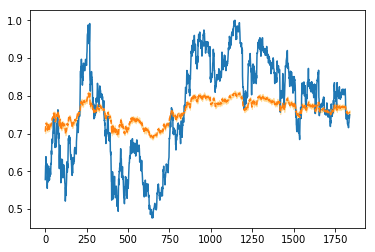

In [320]:
preds = []
for i in range(100):
    sampled_reg_model = guide(data)
    pred = sampled_reg_model(Variable(data_feature_train)).data.numpy().flatten()
    preds.append(pred)

preds = np.array(preds)
mean = np.mean(preds, axis=0)
std = np.std(preds, axis=0) / 10

plt.figure()
x = np.arange(data_target_train.numpy().shape[0])
plt.plot(x, data_target_train.numpy())
plt.plot(x, mean, linestyle = '--')
plt.fill_between(x, mean-std, mean+std, alpha = 0.3, color = 'orange')
plt.show()

In [321]:
optim = Adam_pyro({"lr": 0.01})
svi = SVI(model, guide, optim, loss="ELBO")

N = len(data_feature_train)

for j in range(3000):
    epoch_loss = svi.step(data)
    if j % 100 == 0:
        print(j, "avg loss {}".format(epoch_loss))

0 avg loss 128003.875
100 avg loss 56368.84375
200 avg loss 4646.67822265625
300 avg loss 52695.5390625
400 avg loss 32413.857421875
500 avg loss 82237.2265625
600 avg loss 26400.177734375
700 avg loss 524.1917114257812
800 avg loss 4014.185546875
900 avg loss 571.15966796875
1000 avg loss 26909.94921875
1100 avg loss 1356.96435546875
1200 avg loss 10840.2021484375
1300 avg loss 4208.3427734375
1400 avg loss 15464.9677734375
1500 avg loss -458.71875
1600 avg loss 47.7703857421875
1700 avg loss 11902.3701171875
1800 avg loss -203.803955078125
1900 avg loss -2532.27587890625
2000 avg loss 4208.794921875
2100 avg loss -1334.3199462890625
2200 avg loss -2255.7060546875
2300 avg loss 3714.29443359375
2400 avg loss 10026.3154296875
2500 avg loss 8761.0810546875
2600 avg loss 836.4815673828125
2700 avg loss 8602.3046875
2800 avg loss -2611.075439453125
2900 avg loss -3460.4091796875


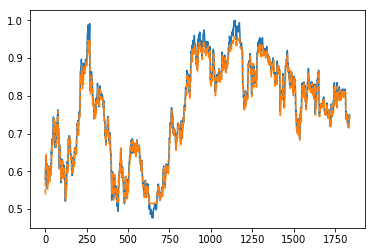

In [322]:
preds = []
for i in range(100):
    sampled_reg_model = guide(data)
    pred = sampled_reg_model(Variable(data_feature_train)).data.numpy().flatten()
    preds.append(pred)

preds = np.array(preds)
mean = np.mean(preds, axis=0)
std = np.std(preds, axis=0) / 10

plt.figure()
x = np.arange(data_target_train.numpy().shape[0])
plt.plot(x, data_target_train.numpy())
plt.plot(x, mean, linestyle = '--')
plt.fill_between(x, mean-std, mean+std, alpha = 0.3, color = 'orange')
plt.show()